In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

from tqdm import tqdm

In [2]:
IRI = np.loadtxt('IRI6.txt', skiprows=100, usecols = [0,1])
z, N_e = IRI[IRI[:,1]!=-1].T

In [3]:
from astropy.constants import m_e, e, R_earth
R_earth = R_earth.to('km').value

In [4]:
omega_plasm = np.sqrt((4 * np.pi * (e.gauss.value ** 2) * N_e / m_e.cgs.value))
n5 = np.sqrt(1 - ((omega_plasm**2)/((2 * np.pi * 5e6) ** 2)))
n8 = np.sqrt(1 - ((omega_plasm**2)/((2 * np.pi * 8e6) ** 2)))
r = z + R_earth
r_ = np.linspace(R_earth, R_earth+1000, 4096)
n5 = interp1d(r, n5, kind = 'cubic', bounds_error=False, fill_value=(n5[0],n5[-1]))
n8 = interp1d(r, n8, kind = 'cubic', bounds_error=False, fill_value=(n8[0],n8[-1]))

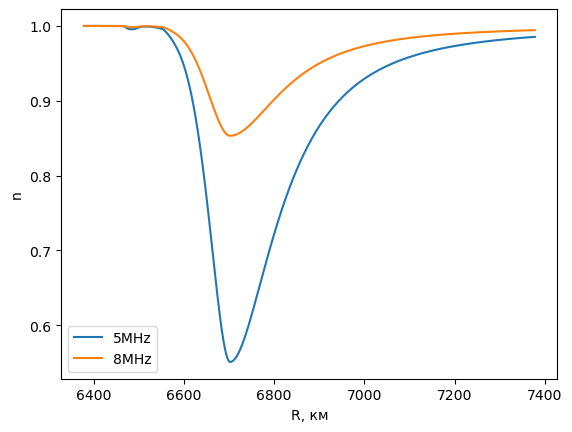

In [5]:
plt.figure()
plt.plot(r_, n5(r_), label='5MHz')
plt.plot(r_, n8(r_), label='8MHz')
plt.xlabel('R, км')
plt.ylabel('n')
plt.legend()
plt.savefig('n.png')

/tmp/ipykernel_529500/1753298380.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda r: n(r)**2, r, dx=3, n=1, order=5)


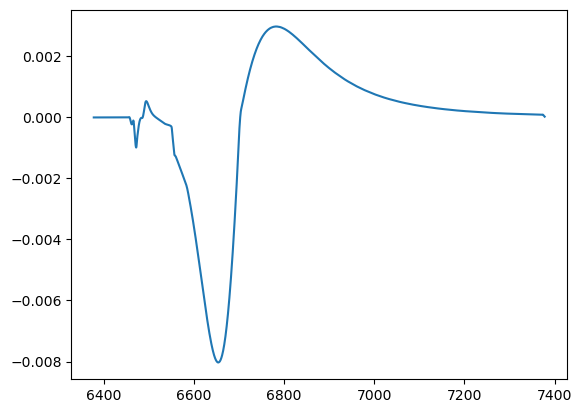

In [6]:
def dn2_dr(n, r):
    return derivative(lambda r: n(r)**2, r, dx=3, n=1, order=5)
plt.plot(r_, dn2_dr(n5, r_))
plt.savefig('dn2_dr.png')

In [7]:
def ode(t, p, n): 
    r,theta,nr,ntheta = p
    if r < R_earth:
        return [0, 0, 0, 0]
    if r > R_earth + 1200e3:
        return [0, 0, 0, 0]
    dr_dt = 1/n(r)**2 * nr
    dtheta_dt = 1/(r*n(r)**2) * ntheta
    dnr_dt = 1/(2*n(r)**2) * dn2_dr(n, r) + ntheta * dtheta_dt
    dntheta_dt = 1/r * -ntheta*dr_dt
    return [dr_dt, dtheta_dt, dnr_dt, dntheta_dt]

def solve(n, r0, teta, t, max_step = None):

    nr0 = n(r0)*np.cos(teta)
    ntheta0 = n(r0)*np.sin(teta)
    
    p0 = [r0, 0, nr0, ntheta0]
    sol = solve_ivp(ode, [t[0], t[-1]], p0, args=(n, ),
                    dense_output=True, max_step = max_step)

    return sol.sol(t)

In [8]:
def calc(n, thetas, t, title, imagename):
    dt = t[1]-t[0]
    colors = plt.cm.viridis(thetas)[::-1]
    D = np.zeros(len(thetas)) * np.nan
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 9]}, sharey=True, figsize=(12,6))
    for i, theta0 in enumerate(thetas):
        r,theta,nr,ntheta = solve(n, R_earth, theta0, t, max_step = dt)
        d = theta*R_earth
        z = r - R_earth
        if z[-1] < 500:
            D[i] = np.interp(0, z, d)
        axs[1].plot(d, z, c = colors[i], linewidth=0.25)
    axs[0].plot(n(r_),r_ - R_earth)
    axs[0].set_xlabel('n')
    axs[1].set_ylim(0, 600)
    axs[1].set_xlim(0, 5e3)
    axs[1].set_xlabel('Distance, km')
    axs[0].set_ylabel('Height, km')
    axs[0].set_xlim(0.5, 1)
    axs[1].set_title(title)
    fig.tight_layout()
    fig.savefig(imagename, dpi=400)
    return D

/tmp/ipykernel_529500/1753298380.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda r: n(r)**2, r, dx=3, n=1, order=5)


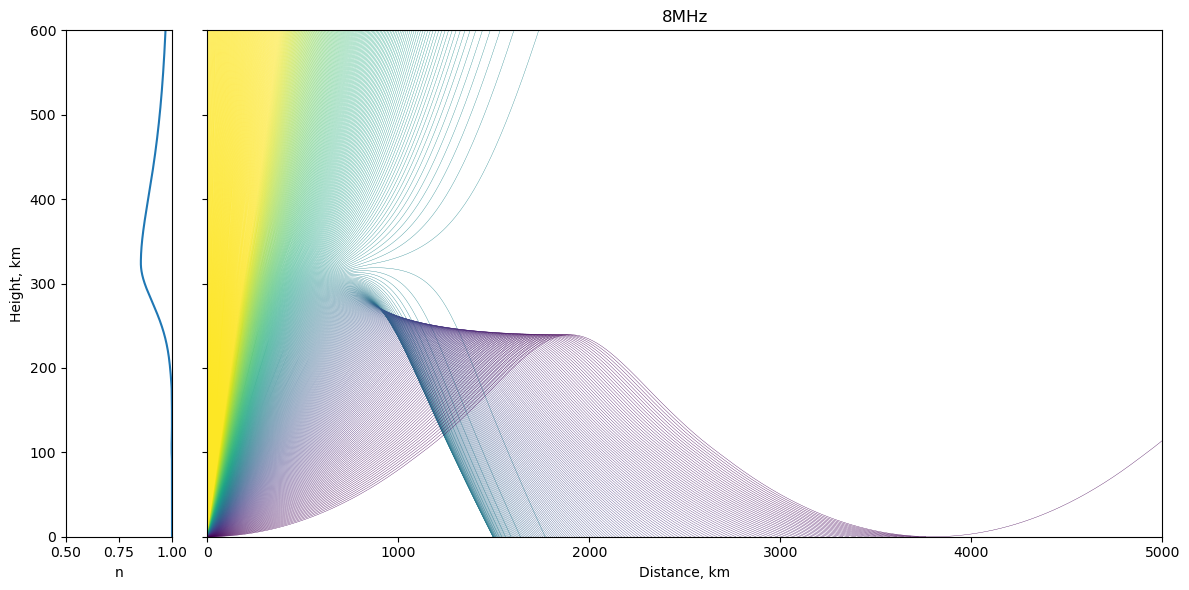

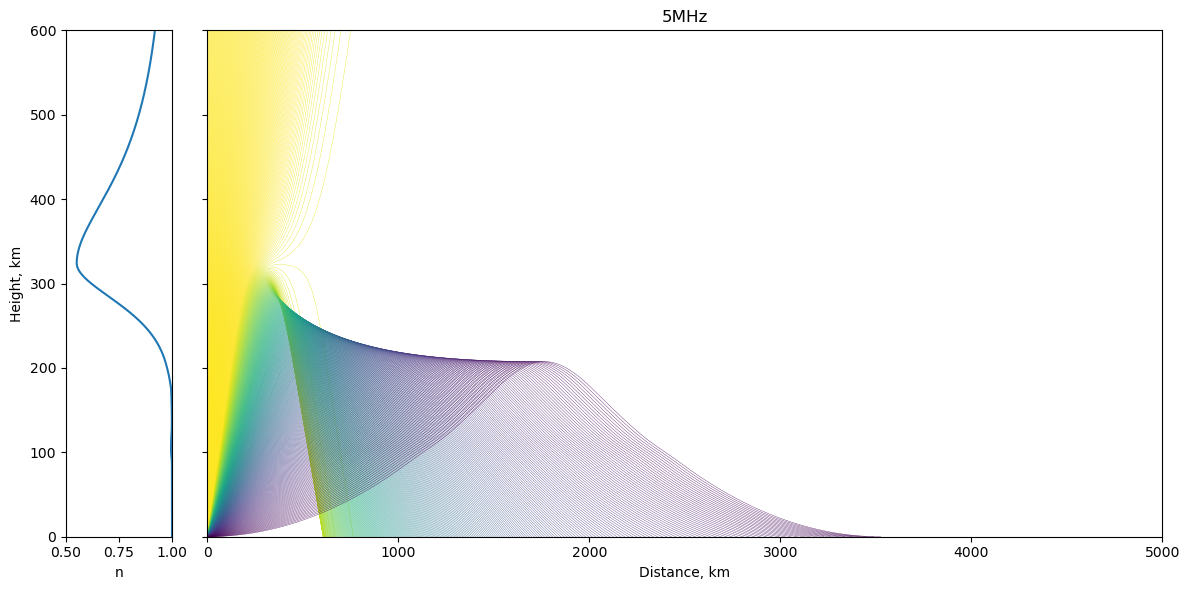

In [9]:
thetas = np.linspace(0,np.pi/2, 2**9)
t = np.linspace(0,8e3, 2**10)
D8 = calc(n8, thetas, t, '8MHz', '8.png')
D5 = calc(n5, thetas, t, '5MHz', '5.png')

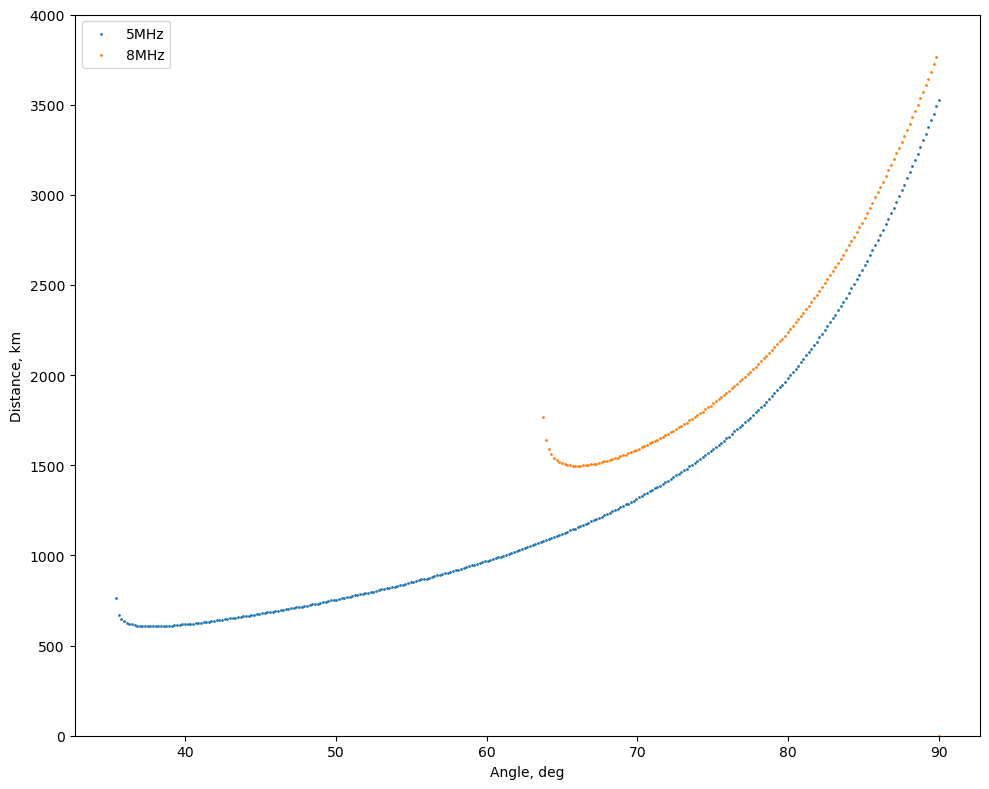

In [10]:
plt.figure(figsize=(10,8))
plt.scatter(thetas/np.pi*180, D5, s = 1, label = '5MHz')
plt.scatter(thetas/np.pi*180, D8, s = 1, label = '8MHz')
plt.xlabel('Angle, deg')
plt.ylabel('Distance, km')
plt.legend()
plt.tight_layout()
plt.savefig('distances.png')
plt.ylim(0,4000)
plt.tight_layout()
plt.savefig('distances_ylim.png')